In [171]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import pyarrow
import numpy as np
import os
import cv2
import imghdr
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy 

In [172]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [173]:
# Specify the path to the directory you want to navigate to
directory_path = "~/Desktop/Data_RSNA"

# Expand the ~ character to your home directory
expanded_path = os.path.expanduser(directory_path)

# Change the current working directory to the specified path
os.chdir(expanded_path)

In [703]:
df = pd.read_csv('train.csv')

In [704]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


KEY POINT : The idea of my first prediction attempt is to build five labels classes, and we will try to predict each one and then we will concatenate the results of each class to constract the final prediction of this model. So, our lables are : class_bowel, class_extravasation, class_kidney, class_liver, class_spleen  

# Part 1 : Data manipulation 

1.1 : Create the five labels classes

In [705]:
df_class_bowel = df[['patient_id','bowel_healthy','bowel_injury']]
df_class_extravasation = df[['patient_id','extravasation_healthy','extravasation_injury']]
df_class_kidney = df[['patient_id','kidney_healthy','kidney_low','kidney_high']]
df_class_liver = df[['patient_id','liver_healthy','liver_low','liver_high']]
df_class_spleen = df[['patient_id','spleen_healthy','spleen_low','spleen_high']]

In [706]:
df_class_bowel

,patient_id,bowel_healthy,bowel_injury
0,10004,1,0
1,10005,1,0
2,10007,1,0
3,10026,1,0
4,10051,1,0
...,...,...,...
3142,9951,1,0
3143,9960,1,0
3144,9961,1,0
3145,9980,1,0


1.2 : knowing the important images data of each one 

In [707]:
No_dup_bowel = df_class_bowel.copy()
No_dup_bowel = No_dup_bowel.drop_duplicates(subset=['bowel_healthy','bowel_injury'])

No_dup_extravasation = df_class_extravasation.copy()
No_dup_extravasation = No_dup_extravasation.drop_duplicates(subset=['extravasation_healthy', 'extravasation_injury'])

No_dup_kidney = df_class_kidney.copy()
No_dup_kidney = No_dup_kidney.drop_duplicates(subset=['kidney_healthy', 'kidney_low', 'kidney_high'])

No_dup_liver = df_class_liver.copy()
No_dup_liver = No_dup_liver.drop_duplicates(subset=['liver_healthy','liver_low','liver_high'])

No_dup_spleen = df_class_spleen.copy()
No_dup_spleen = No_dup_spleen.drop_duplicates(subset=['spleen_healthy','spleen_low','spleen_high'])

In [708]:
No_dup_bowel

,patient_id,bowel_healthy,bowel_injury
0,10004,1,0
5,10065,0,1


bowel_patiend_id = [ 10004 , 10065]

In [709]:
No_dup_extravasation

,patient_id,extravasation_healthy,extravasation_injury
0,10004,0,1
1,10005,1,0


extravasation_patiend_id = [10004 , 10005]

In [710]:
No_dup_kidney

,patient_id,kidney_healthy,kidney_low,kidney_high
0,10004,0,1,0
1,10005,1,0,0
136,12600,0,0,1


kidney_patiend_id = [10004 , 10005 , 12600]

In [711]:
No_dup_liver

,patient_id,liver_healthy,liver_low,liver_high
0,10004,1,0,0
12,10163,0,1,0
51,10937,0,0,1


liver_patiend_id = [10004 , 10163 , 10937]

In [712]:
No_dup_spleen

,patient_id,spleen_healthy,spleen_low,spleen_high
0,10004,0,0,1
1,10005,1,0,0
4,10051,0,1,0


spleen_patiend_id = [10004 , 10005 , 10051]

# Part 2 : First Task : Neural Network Model for Bowel_[injury/healthy] Prediction (the first label class)


In [713]:
img = cv2.imread(os.path.join(expanded_path, 'bowel_label_class' ,'bowel_JPG' , 'bowel_healthy_JPG' , '1000.jpg '))

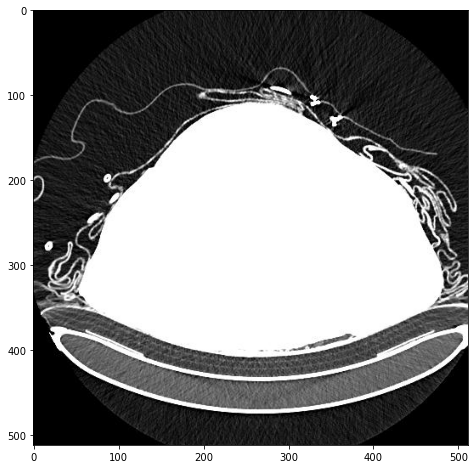

In [714]:
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.show()

loading the data 

In [174]:
data_bowel_class = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path, 'bowel_label_class' ,'bowel_JPG' ), shuffle = True)

Found 162 files belonging to 2 classes.


In [175]:
len(data_bowel_class)

6

In [176]:
#data 1 and data are similaire but the first instruction is more sophisticated 
#data1 = tf.keras.utils.image_dataset_from_directory('C:\\Users\\PC/Desktop/Data_RSNA/bowel_label_class\\bowel_JPG')

In [177]:
data_iterator_bowel_class = data_bowel_class.as_numpy_iterator()

In [178]:
batch_bowel_class = data_iterator_bowel_class.next()

In [179]:
batch_bowel_class

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [762]:
len(batch_bowel_class[0]) , len(batch_bowel_class[1]) , batch_bowel_class[0].shape , batch_bowel_class[1].shape # automaticlly convert them into a consistent size 

(32, 32, (32, 256, 256, 3), (32,))

bowel_healthy = 0     bowel_injury = 1 

Preprocess Data

In [180]:
data_bowel_class = data_bowel_class.map(lambda x,y : (x/255 , y))

In [181]:
scaled_iterator_bowel_class = data_bowel_class.as_numpy_iterator()

In [182]:
batch_scaled_bowel_class = scaled_iterator_bowel_class.next()

In [183]:
np.max(batch_scaled_bowel_class[0]) , np.min(batch_scaled_bowel_class[0])

(1.0, 0.0)

our data content 162 files (images) so this is what mean that we have 6 batches which 5 batches content 32 images and one content 2 images 5x32 + 1x2 = 162

2.6 : splitting data

In [217]:
len(data_bowel_class)

6

In [203]:
train_size = 3
val_size = 2
test_size = 1

In [204]:
train_bowel_class  = data_bowel_class.take(train_size)
val_bowel_class  = data_bowel_class.skip(train_size).take(val_size)
test_bowel_class  = data_bowel_class.skip(train_size + val_size).take(test_size)

In [186]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout 

In [205]:
model_bowel_class = Sequential()

In [206]:
model_bowel_class.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_bowel_class.add(MaxPooling2D())            

model_bowel_class.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_bowel_class.add(MaxPooling2D())

model_bowel_class.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_bowel_class.add(MaxPooling2D())

model_bowel_class.add(Flatten())          

model_bowel_class.add(Dense(256, activation = 'relu'))
model_bowel_class.add(Dense(1, activation = 'sigmoid'))

In [207]:
model_bowel_class.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [208]:
model_bowel_class.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 16)       

Train

In [209]:
logdir_bowel_class  = os.path.join(os.path.join(expanded_path, 'bowel_label_class' , 'bowel_class_logs'))

In [210]:
tensorboard_callback_bowel_class = tf.keras.callbacks.TensorBoard(log_dir = logdir_bowel_class )

In [211]:
hist_bowel_class = model_bowel_class.fit(train_bowel_class, epochs = 20 , validation_data = val_bowel_class, callbacks = [tensorboard_callback_bowel_class])

Epoch 1/20
3/3 [==============================] - 19s 4s/step - loss: 1.2765 - accuracy: 0.5000 - val_loss: 0.7570 - val_accuracy: 0.5312
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 0.4637 - accuracy: 0.7708 - val_loss: 0.2172 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 9s 2s/step - loss: 0.1466 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 9s 2s/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 3.8003e-04 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 9s 2s/step - loss: 2.9569e-04 - accuracy: 1.0000 - val_loss: 2.2226e-04 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 9s 2s/step - loss: 1.2710e-04 - accuracy: 1.0000 - val_loss: 2.7814e-05 - val_accuracy: 1.0000
Epoch 8/20
3/3 [====

In [789]:
hist_bowel_class.history 

{'loss': [0.5654545426368713,
  0.15447364747524261,
  0.019883383065462112,
  0.001921219751238823,
  0.00019608228467404842,
  1.5987125152605586e-05,
  4.3025200284319e-05,
  1.9890559997293167e-05,
  1.9253469872637652e-05,
  5.213583790464327e-06,
  1.6517091125933803e-06,
  7.884368642407935e-07,
  2.5870420472529077e-07,
  1.0749099033091625e-07,
  5.484034559799511e-08,
  2.3634518342419142e-08,
  2.232201445906412e-08,
  6.6094751893786e-09,
  4.74017491924883e-09,
  6.767642446448008e-09],
 'accuracy': [0.71875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.26151248812675476,
  0.04197673499584198,
  0.002101111225783825,
  0.0005002811085432768,
  1.211565722769592e-05,
  1.2284640433790628e-05,
  4.74881635454949e-05,
  2.8113508960814215e-05,
  3.2117725368152605e-08,
  1.1661549024211126e-06,
  7.138315822885488e-07,
  2.0743138406942307e-07,
  1.226280801347457e-07,
  

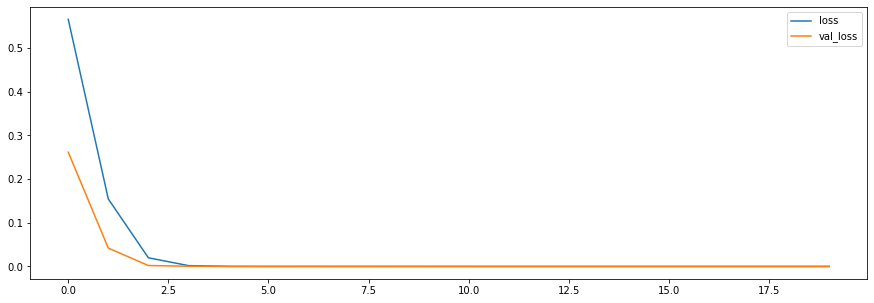

In [790]:
plt.figure(figsize = (15,5))
plt.plot(hist_bowel_class.history['loss'], label ='loss')
plt.plot(hist_bowel_class.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.show()

Model Evaluation  

In [218]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy 

In [219]:
pre_bowel_class = Precision()
re_bowel_class = Recall()
acc_bowel_class = BinaryAccuracy()

In [220]:
for batch in test_bowel_class.as_numpy_iterator():
    X , y = batch
    yhat = model_bowel_class.predict(X)
    pre_bowel_class.update_state(y, yhat)
    re_bowel_class.update_state(y, yhat)
    acc_bowel_class.update_state(y, yhat) 

1/1 [==============================] - 0s 191ms/step


In [222]:
pre_bowel_class.result().numpy() , re_bowel_class.result().numpy() , acc_bowel_class.result().numpy()

(1.0, 1.0, 1.0)

2.9 : Test

In [409]:
dicom_directory = os.path.join(expanded_path , 'bowel_test')
jpeg_directory = os.path.join(expanded_path , 'bowel_test')

dicom_path = os.path.join(dicom_directory, '30.dcm')
dicom_data = pydicom.dcmread(dicom_path)
pixel_array = dicom_data.pixel_array
image = Image.fromarray(pixel_array).convert('RGB')
jpeg_image = '30' + '.jpg'
jpeg_path = os.path.join(jpeg_directory, jpeg_image)
image.save(jpeg_path)


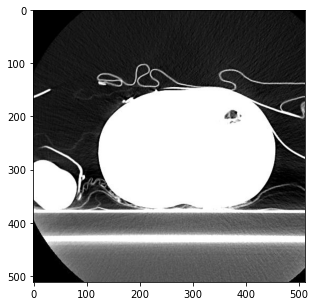

In [809]:
plt.figure(figsize = (10,5))
img_bowel = cv2.imread(os.path.join(expanded_path, 'bowel_label_class' , 'bowel_test' , '30.jpg'))
plt.imshow(img_bowel)
plt.show()

In [810]:
resize_bowel_class = tf.image.resize(img_bowel, (256,256))

In [811]:
yhat_bowel = model_bowel_class.predict(np.expand_dims(resize_bowel_class/255 , 0))

1/1 [==============================] - 0s 197ms/step


In [812]:
yhat_bowel

array([[0.9999812]], dtype=float32)

Last Step

In [223]:
def bowel_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'bowel_healthy' : [] , 'bowel_injury' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_bowel = cv2.imread(image_path)
            resize = tf.image.resize(image_bowel, (256,256))
            yhat_bowel = model_bowel_class.predict(np.expand_dims(resize/255 , 0))
            bowel_injury = float(yhat_bowel)
            bowel_healthy = float(1 - yhat_bowel)
            data['bowel_healthy'].append(bowel_healthy)
            data['bowel_injury'].append(bowel_injury)
        
    bowel_df = pd.DataFrame(data)
    bowel_df.to_csv('bowel_prediction.csv' , index = False)
    
    return bowel_df



In [225]:
jpeg_directory = os.path.join(expanded_path, 'bowel_label_class' , 'bowel_test')
patient_id = [48843]
bowel_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 141ms/step


,patient_id,bowel_healthy,bowel_injury
0,48843,0.0,1.0


# Part 3 : Second Task : Neural Network Model for extravasation_[injury/healthy] Prediction (the second label class)

leading data

In [226]:
data_extravasation_class = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'extravasation_label_class' ,'extravasation_JPG') , shuffle = True)

Found 162 files belonging to 2 classes.


In [227]:
len(data_extravasation_class)

6

In [228]:
data_iterator_extravasation_class = data_extravasation_class.as_numpy_iterator()

In [229]:
batch_extravasation_class = data_iterator_extravasation_class.next()

In [230]:
batch_extravasation_class

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

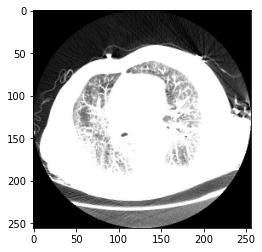

In [886]:
img = batch_extravasation_class[0][1]
plt.imshow(img.astype(int))
plt.show()

extravasation_healthy = 0  , extravasation_injury = 1

Data Processing 

In [231]:
data_extravasation_class = data_extravasation_class.map(lambda x,y : (x/255 , y))

In [232]:
scaled_iterator_extravasation_class = data_extravasation_class.as_numpy_iterator()

In [233]:
batch_extravasation_class = scaled_iterator_extravasation_class.next()

In [234]:
np.max(batch_extravasation_class[0][1]) , np.min(batch_extravasation_class[0][1])

(1.0, 0.0)

Splitting data

In [235]:
train_size = 3
val_size = 2
test_size = 1

In [237]:
train_extravasation_class = data_extravasation_class.take(train_size)
val_extravasation_class = data_extravasation_class.skip(train_size).take(val_size)
test_extravasation_class = data_extravasation_class.skip(train_size + val_size).take(test_size)

In [238]:
model_extravasation_class = Sequential()

In [239]:
model_extravasation_class.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_extravasation_class.add(MaxPooling2D())            

model_extravasation_class.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_extravasation_class.add(MaxPooling2D())

model_extravasation_class.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_extravasation_class.add(MaxPooling2D())

model_extravasation_class.add(Flatten())          

model_extravasation_class.add(Dense(256, activation = 'relu'))
model_extravasation_class.add(Dense(1, activation = 'sigmoid'))

In [240]:
model_extravasation_class.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [241]:
model_extravasation_class.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 16)       

Train

In [242]:
logdir_extravasation_class = os.path.join(expanded_path , 'extravasation_label_class', 'logs_extravasation')

In [243]:
tensorboard_callback_extravasation_class = tf.keras.callbacks.TensorBoard(log_dir = logdir_extravasation_class)

In [244]:
hist_extravasation_class = model_extravasation_class.fit(train_extravasation_class, epochs = 20 , validation_data = val_extravasation_class, callbacks = [tensorboard_callback_extravasation_class])

Epoch 1/20
3/3 [==============================] - 17s 4s/step - loss: 0.7259 - accuracy: 0.6458 - val_loss: 0.3997 - val_accuracy: 0.8438
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 0.2708 - accuracy: 0.9688 - val_loss: 0.0587 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 9s 2s/step - loss: 0.0411 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 11s 3s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 9s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.6882e-04 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 9s 2s/step - loss: 2.3881e-04 - accuracy: 1.0000 - val_loss: 3.0055e-05 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 1.4033e-05 - accuracy: 1.0000 - val_loss: 1.8603e-06 - val_accuracy: 1.0000
Epoch 8/20
3/3 [===

Evaluation 

In [245]:
pre_extravasation_class = Precision()
re_extravasation_class = Recall()
acc_extravasation_class = BinaryAccuracy()

In [246]:
for batch in test_extravasation_class.as_numpy_iterator():
    X , y = batch
    yhat = model_extravasation_class.predict(X)
    pre_extravasation_class.update_state(y, yhat)
    re_extravasation_class.update_state(y, yhat)
    acc_extravasation_class.update_state(y, yhat)

1/1 [==============================] - 0s 471ms/step


In [247]:
pre_extravasation_class.result().numpy(), re_extravasation_class.result().numpy() , acc_extravasation_class.result().numpy()

(1.0, 1.0, 1.0)

last step

In [252]:
def extravasation_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'extravasation_healthy' : [] , 'extravasation_injury' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_extravasation = cv2.imread(image_path)
            resize = tf.image.resize(image_extravasation, (256,256))
            yhat_extravasation = model_extravasation_class.predict(np.expand_dims(resize/255 , 0))
            extravasation_injury= float(yhat_extravasation)
            extravasation_healthy = float(1 - yhat_extravasation)
            data['extravasation_healthy'].append(extravasation_healthy)
            data['extravasation_injury'].append(extravasation_injury)
        
    extravasation_df = pd.DataFrame(data)
    extravasation_df.to_csv('extravasation_prediction.csv' , index = False)
    
    return extravasation_df


In [254]:
jpeg_directory = os.path.join(expanded_path, 'extravasation_label_class', 'extravasation_test')
patient_id = [48843]
extravasation_prediction(jpeg_directory , patient_id)


1/1 [==============================] - 0s 155ms/step


,patient_id,extravasation_healthy,extravasation_injury
0,48843,0.0,1.0


# Part 4 : Third Task : Classification of level 1: Neural Network Model for kidney_[injury/healthy] Prediction (the third label class)

loading data

In [255]:
data_kidney_level_1 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'kidney_label_class' ,'kidney_JPG', 'data_kidney_level_1') , shuffle = True)

Found 215 files belonging to 2 classes.


In [256]:
len(data_kidney_level_1)

7

In [257]:
data_iterator_kidney_level_1 = data_kidney_level_1.as_numpy_iterator()

In [258]:
batch_kidney_level_1 = data_iterator_kidney_level_1.next()

In [259]:
batch_kidney_level_1

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [1186]:
img_1 = batch_kidney_level_1[0][0]
img_2 = batch_kidney_level_1[0][1]

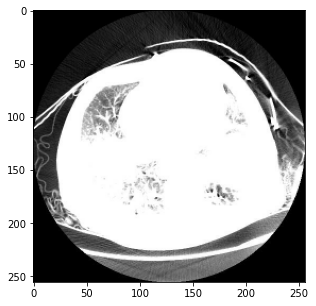

In [1187]:
plt.figure(figsize = (10,5))
plt.imshow(img_1.astype(int))
plt.show()

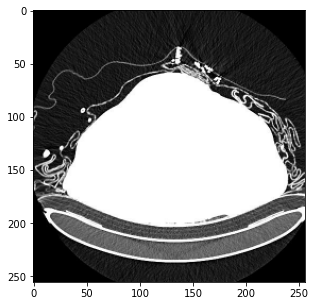

In [1188]:
plt.figure(figsize = (10,5))
plt.imshow(img_2.astype(int))
plt.show()

kidney_injury = 1                        kidney_healthy = 0

data processing 

In [260]:
data_kidney_level_1 = data_kidney_level_1.map(lambda x,y : (x/255 , y))

In [261]:
scaled_iterator_kidney_level_1 = data_kidney_level_1.as_numpy_iterator()

In [262]:
batch_kidney_level_1 = scaled_iterator_kidney_level_1.next()

In [263]:
np.max(batch_kidney_level_1[0][0]) , np.min(batch_kidney_level_1[0][0])

(1.0, 0.0)

data splitting 

In [264]:
len(data_kidney_level_1)

7

In [265]:
train_size = 4
val_size = 2
test_size = 1

In [266]:
train_kidney_level_1 = data_kidney_level_1.take(train_size)
val_kidney_level_1 = data_kidney_level_1.skip(train_size).take(val_size)
test_kidney_level_1 = data_kidney_level_1.skip(train_size + val_size).take(test_size)

Model

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout

In [268]:
model_kidney_level_1 = Sequential()

In [269]:
model_kidney_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_kidney_level_1.add(MaxPooling2D())            

model_kidney_level_1.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_kidney_level_1.add(MaxPooling2D())

model_kidney_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_kidney_level_1.add(MaxPooling2D())

model_kidney_level_1.add(Flatten())          

model_kidney_level_1.add(Dense(256, activation = 'relu'))
model_kidney_level_1.add(Dense(1, activation = 'sigmoid'))

In [270]:
model_kidney_level_1.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [271]:
model_kidney_level_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 16)       

train

In [272]:
logdir_kidney_level_1 = os.path.join(expanded_path , 'kidney_label_class', 'logs_kidney_level_1')

In [273]:
tensorboard_callback_kidney_level_1 = tf.keras.callbacks.TensorBoard(log_dir = logdir_kidney_level_1)

In [274]:
hist_kidney_level_1 = model_kidney_level_1.fit(train_kidney_level_1, epochs = 20 , validation_data = val_kidney_level_1, callbacks = [tensorboard_callback_kidney_level_1])

Epoch 1/20
4/4 [==============================] - 20s 3s/step - loss: 1.4048 - accuracy: 0.7422 - val_loss: 0.6273 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 0.4832 - accuracy: 0.7891 - val_loss: 0.3710 - val_accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 11s 2s/step - loss: 0.2935 - accuracy: 0.8359 - val_loss: 0.1598 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 11s 2s/step - loss: 0.1564 - accuracy: 0.9922 - val_loss: 0.0990 - val_accuracy: 0.9844
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.0557 - accuracy: 0.9922 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 12s 2s/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 11s 2s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 8/20
4/4 [====================

evaluation

In [279]:
pre_kidney_level_1 = Precision()
re_kidney_level_1 = Recall()
acc_kidney_level_1 = BinaryAccuracy()

In [280]:
for batch in test_kidney_level_1.as_numpy_iterator():
    X , y = batch
    yhat = model_kidney_level_1.predict(X)
    pre_kidney_level_1.update_state(y, yhat)
    re_kidney_level_1.update_state(y, yhat)
    acc_kidney_level_1.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [281]:
pre_kidney_level_1.result().numpy(), re_kidney_level_1.result().numpy() ,acc_kidney_level_1.result().numpy()

(1.0, 1.0, 1.0)

last step

In [282]:
def kidney_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'kidney_healthy' : [] , 'kidney_injury' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_kidney_level_1 = cv2.imread(image_path)
            resize = tf.image.resize(image_kidney_level_1, (256,256))
            yhat_kidney_level_1= model_kidney_level_1.predict(np.expand_dims(resize/255 , 0))
            kidney_injury = float(yhat_kidney_level_1)
            kidney_healthy = float(1 - yhat_kidney_level_1)
            data['kidney_healthy'].append(kidney_healthy)
            data['kidney_injury'].append(kidney_injury)
        
    kidney_df = pd.DataFrame(data)
    kidney_df.to_csv('kidney_prediction.csv' , index = False)
    
    return kidney_df


In [286]:
jpeg_directory = os.path.join(expanded_path, 'kidney_label_class', 'kidney_level_2_test')
patient_id = [48843]
kidney_prediction(jpeg_directory , patient_id)


1/1 [==============================] - 0s 224ms/step


,patient_id,kidney_healthy,kidney_injury
0,48843,0.000005,0.999995


# Part 4 : Third Task : Classification of level 2: Neural Network Model for kidney_[injury/healthy] Prediction (the third label class)

loading data

In [287]:
data_kidney_level_2 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'kidney_label_class' ,'kidney_JPG', 'data_kidney_level_2') , shuffle = True)

Found 162 files belonging to 2 classes.


In [288]:
len(data_kidney_level_2)

6

In [289]:
data_iterator_kidney_level_2 = data_kidney_level_2.as_numpy_iterator()

In [290]:
batch_kidney_level_2 = data_iterator_kidney_level_2.next()

In [291]:
batch_kidney_level_2

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [1217]:
img_1 = batch_kidney_level_2[0][0]
img_2 = batch_kidney_level_2[0][1]

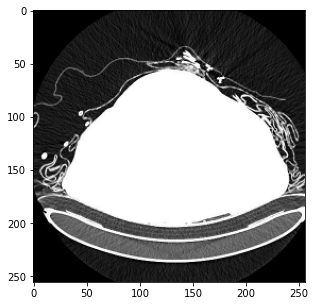

In [1218]:
plt.figure(figsize = (10,5))
plt.imshow(img_1.astype(int))
plt.show()

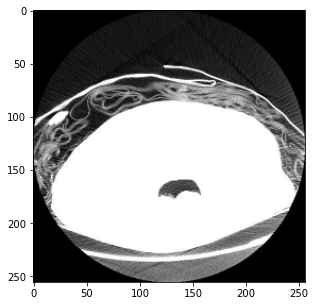

In [1219]:
plt.figure(figsize = (10,5))
plt.imshow(img_2.astype(int))
plt.show()

high kidney_injury = 0 , low kidney_injury = 1

Data Processing 

In [292]:
data_kidney_level_2 = data_kidney_level_2.map(lambda x, y  : (x/255 , y))

In [293]:
scaled_iterator_kidney_level_2 = data_kidney_level_2.as_numpy_iterator()

In [294]:
batch_kidney_level_2 = scaled_iterator_kidney_level_2.next()

In [295]:
np.max(batch_kidney_level_2[0][0]) , np.min(batch_kidney_level_2[0][0])

(1.0, 0.0)

Splitting Data

In [296]:
len(data_kidney_level_2)

6

In [297]:
train_size = 3
val_size = 2
test_size = 1

In [298]:
train_kidney_level_2 = data_kidney_level_2.take(train_size)
val_kidney_level_2 = data_kidney_level_2.skip(train_size).take(val_size)
test_kidney_level_2 = data_kidney_level_2.skip(train_size + val_size).take(test_size)

Model

In [299]:
model_kidney_level_2 = Sequential()

In [300]:
model_kidney_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_kidney_level_2.add(MaxPooling2D())            

model_kidney_level_2.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_kidney_level_2.add(MaxPooling2D())

model_kidney_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_kidney_level_2.add(MaxPooling2D())

model_kidney_level_2.add(Flatten())          

model_kidney_level_2.add(Dense(256, activation = 'relu'))
model_kidney_level_2.add(Dense(1, activation = 'sigmoid'))

In [301]:
model_kidney_level_2.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [302]:
model_kidney_level_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 16)       

Train

In [303]:
logdir_kidney_level_2 = os.path.join(expanded_path , 'kidney_label_class', 'logs_kidney_level_2')

In [304]:
tensorboard_callback_kidney_level_2 = tf.keras.callbacks.TensorBoard(log_dir = logdir_kidney_level_2)

In [305]:
hist_kidney_level_2 = model_kidney_level_2.fit(train_kidney_level_2, epochs = 20 , validation_data = val_kidney_level_2, callbacks = [tensorboard_callback_kidney_level_2])

Epoch 1/20
3/3 [==============================] - 16s 4s/step - loss: 0.8111 - accuracy: 0.4375 - val_loss: 0.3750 - val_accuracy: 0.9531
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 0.2487 - accuracy: 1.0000 - val_loss: 0.0834 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 9s 2s/step - loss: 0.0790 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 9s 2s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.7621e-04 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 9s 2s/step - loss: 9.8748e-05 - accuracy: 1.0000 - val_loss: 7.1295e-06 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 9s 2s/step - loss: 3.7486e-06 - accuracy: 1.0000 - val_loss: 3.0340e-07 - val_accuracy: 1.0000
Epoch 8/20
3/3 [====

Evaluation

In [311]:
pre_kidney_level_2 = Precision()
re_kidney_level_2 = Recall()
acc_kidney_level_2 = BinaryAccuracy()

In [312]:
for batch in test_kidney_level_2.as_numpy_iterator():
    X , y = batch
    yhat = model_kidney_level_2.predict(X)
    pre_kidney_level_2.update_state(y, yhat)
    re_kidney_level_2.update_state(y, yhat)
    acc_kidney_level_2.update_state(y, yhat)

1/1 [==============================] - 0s 250ms/step


In [313]:
pre_kidney_level_2.result().numpy() , re_kidney_level_2.result().numpy() , acc_kidney_level_2.result().numpy()

(1.0, 1.0, 1.0)

last step 

In [314]:
def kidney_low_high_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'kidney_low' : [] , 'kidney_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_kidney_level_2 = cv2.imread(image_path)
            resize = tf.image.resize(image_kidney_level_2, (256,256))
            yhat_kidney_level_2= model_kidney_level_2.predict(np.expand_dims(resize/255 , 0))
            kidney_injury_low = float(yhat_kidney_level_2)
            kidney_injury_high = float(1 - yhat_kidney_level_2)
            data['kidney_low'].append(kidney_injury_low)
            data['kidney_high'].append(kidney_injury_high)
        
    kidney_low_high_df = pd.DataFrame(data)
    kidney_low_high_df.to_csv('kidney_low_high.csv' , index = False)
    
    return kidney_low_high_df


In [316]:
jpeg_directory = os.path.join(expanded_path, 'kidney_label_class', 'kidney_level_2_test')
patient_id = [48843]
kidney_low_high_prediction(jpeg_directory , patient_id)


1/1 [==============================] - 0s 295ms/step


,patient_id,kidney_low,kidney_high
0,48843,1.0,0.0


# Part 4 : Third Task : Regrouping of Levels 1 and 2 : Neural Network Model for kidney_[injury/healthy] Prediction (the third label class)

In [317]:
def kidney_finally_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'kidney_healthy' : [] , 'kidney_low' : [] , 'kidney_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_kidney = cv2.imread(image_path)
            resize = tf.image.resize(image_kidney, (256,256))
            yhat_kidney_level_1 = model_kidney_level_1.predict(np.expand_dims(resize/255 , 0))
            yhat_kidney_level_2 = model_kidney_level_2.predict(np.expand_dims(resize/255 , 0))
            kidney_injury = float(yhat_kidney_level_1)
            kidney_healthy = float(1 - yhat_kidney_level_1)
            kidney_injury_low = float(yhat_kidney_level_2)
            kidney_injury_high = float(1 - yhat_kidney_level_2)
            kidney_low = kidney_injury*kidney_injury_low
            kidney_high = kidney_injury*kidney_injury_high
            data['kidney_healthy'].append(kidney_healthy)
            data['kidney_low'].append(kidney_low)
            data['kidney_high'].append(kidney_high)
        
    kidney_df = pd.DataFrame(data)
    kidney_df.to_csv('kidney_prediction.csv' , index = False)
    
    return kidney_df


In [320]:
jpeg_directory = os.path.join(expanded_path, 'kidney_label_class', 'kidney_level_2_test')
patient_id = [48843]
kidney_finally_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 1s 600ms/step


,patient_id,kidney_healthy,kidney_low,kidney_high
0,48843,0.999999,1.033158e-16,9.361985e-07


# Part 5 : Fourth Task : Classification of level 1 : Neural Network Model for liver_[injury/healthy] Prediction (the fourth label class)

In [327]:
data_liver_level_1 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'liver_label_class' ,'liver_JPG', 'data_liver_level_1') , shuffle = True)

Found 230 files belonging to 2 classes.


In [328]:
len(data_liver_level_1)

8

In [329]:
data_iterator_liver_level_1 = data_liver_level_1.as_numpy_iterator()

In [330]:
batch_liver_level_1 = data_iterator_liver_level_1.next()

In [66]:
batch_liver_level_1

(array([[[[  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          ...,
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ]],
 
         [[  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          ...,
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ]],
 
         [[  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          ...,
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ]],
 
         ...,
 
         [[ 95.25,  95.25,  95.25],
          [ 99.25,  99.25,  99.25],
          [102.75, 102.75, 102.75],
          ...,
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ],
          [  0.  ,   0.  ,   0.  ]],
 
         [[ 93.75,  93.75,  93.75],
          [ 

In [67]:
img_1 = batch_liver_level_1[0][0]
img_2 = batch_liver_level_1[0][1]

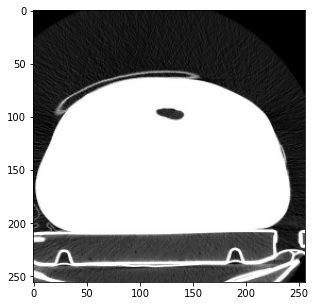

In [68]:
plt.figure(figsize = (10,5))
plt.imshow(img_1.astype(int))
plt.show()

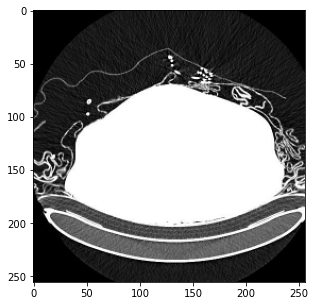

In [69]:
plt.figure(figsize = (10,5))
plt.imshow(img_2.astype(int))
plt.show()

healthy case = 0  injury case = 1 

In [331]:
data_liver_level_1 = data_liver_level_1.map(lambda x, y  : (x/255 , y))

In [332]:
scaled_iterator_liver_level_1 = data_liver_level_1.as_numpy_iterator()

In [333]:
batch_liver_level_1 = scaled_iterator_liver_level_1.next()

In [334]:
np.max(batch_liver_level_1[0][0]) , np.min(batch_liver_level_1[0][0])

(1.0, 0.0)

In [335]:
len(data_liver_level_1)

8

In [336]:
train_size = 5
val_size = 2
test_size = 1

In [337]:
train_liver_level_1 = data_liver_level_1.take(train_size)
val_liver_level_1 = data_liver_level_1.skip(train_size).take(val_size)
test_liver_level_1 = data_liver_level_1.skip(train_size + val_size).take(test_size)

In [338]:
model_liver_level_1 = Sequential()

In [339]:
model_liver_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_liver_level_1.add(MaxPooling2D())            

model_liver_level_1.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_liver_level_1.add(MaxPooling2D())

model_liver_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_liver_level_1.add(MaxPooling2D())

model_liver_level_1.add(Flatten())          

model_liver_level_1.add(Dense(256, activation = 'relu'))
model_liver_level_1.add(Dense(1, activation = 'sigmoid'))

In [340]:
model_liver_level_1.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [341]:
model_liver_level_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 16)      

In [342]:
logdir_liver_level_1 = os.path.join(expanded_path , 'liver_label_class', 'logs_liver_level_1')

In [343]:
tensorboard_callback_liver_level_1 = tf.keras.callbacks.TensorBoard(log_dir = logdir_liver_level_1)

In [344]:
hist_liver_level_1 = model_liver_level_1.fit(train_liver_level_1, epochs = 20 , validation_data = val_liver_level_1, callbacks = [tensorboard_callback_liver_level_1])

Epoch 1/20
5/5 [==============================] - 18s 2s/step - loss: 1.2892 - accuracy: 0.6313 - val_loss: 0.5758 - val_accuracy: 0.9844
Epoch 2/20
5/5 [==============================] - 11s 2s/step - loss: 0.4512 - accuracy: 0.8188 - val_loss: 0.2762 - val_accuracy: 1.0000
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.1610 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 1.0000
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 8s 2s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 6.0727e-04 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 1.9707e-04 - accuracy: 1.0000 - val_loss: 4.7333e-05 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 8s 2s/step - loss: 5.5517e-05 - accuracy: 1.0000 - val_loss: 1.6236e-05 - val_accuracy: 1.0000
Epoch 8/20
5/5 [==

In [345]:
pre_liver_level_1 = Precision()
re_liver_level_1 = Recall()
acc_liver_level_1 = BinaryAccuracy()

In [346]:
for batch in test_liver_level_1.as_numpy_iterator():
    X , y = batch
    yhat = model_liver_level_1.predict(X)
    pre_liver_level_1.update_state(y, yhat)
    re_liver_level_1.update_state(y, yhat)
    acc_liver_level_1.update_state(y, yhat)

1/1 [==============================] - 1s 545ms/step


In [347]:
pre_liver_level_1.result().numpy() , re_liver_level_1.result().numpy() , acc_liver_level_1.result().numpy()

(1.0, 1.0, 1.0)

In [348]:
def liver_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'liver_healthy' : [] , 'liver_injury' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_liver_level_1 = cv2.imread(image_path)
            resize = tf.image.resize(image_liver_level_1, (256,256))
            yhat_liver_level_1= model_liver_level_1.predict(np.expand_dims(resize/255 , 0))
            liver_injury = float(yhat_liver_level_1)
            liver_healthy = float(1 - yhat_liver_level_1)
            data['liver_healthy'].append(liver_healthy)
            data['liver_injury'].append(liver_injury)
        
    liver_df = pd.DataFrame(data)
    liver_df.to_csv('liver_prediction.csv' , index = False)
    
    return liver_df


In [89]:
jpeg_directory = os.path.join(expanded_path, 'liver_label_class', 'liver_test_level_1')
patient_id = [48843]
liver_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 136ms/step


,patient_id,liver_healthy,liver_injury
0,48843,1.788139e-07,1.0


# Part 5 : Fifth Task : Classification of level 2 : Neural Network Model for liver_[injury/healthy] Prediction (the fourth label class)

In [349]:
data_liver_level_2 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'liver_label_class' ,'liver_JPG', 'data_liver_level_2') , shuffle = True)

Found 149 files belonging to 2 classes.


In [350]:
len(data_liver_level_2)

5

In [351]:
data_iterator_liver_level_2 = data_liver_level_2.as_numpy_iterator()

In [352]:
batch_liver_level_2 = data_iterator_liver_level_2.next()

In [10]:
batch_liver_level_2

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [11]:
img_1 = batch_liver_level_2[0][0] 
img_2 = batch_liver_level_2[0][1]

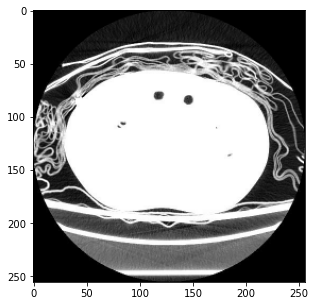

In [12]:
plt.figure(figsize = (10,5))
plt.imshow(img_1.astype(int))
plt.show()

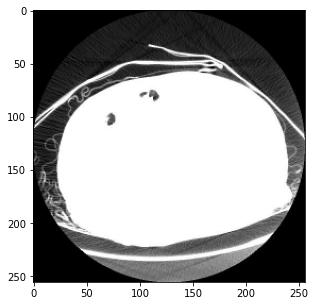

In [13]:
plt.figure(figsize = (10,5))
plt.imshow(img_2.astype(int))
plt.show()

as per usual high = 0  , low = 1

In [353]:
data_liver_level_2 = data_liver_level_2.map(lambda x, y  : (x/255 , y))

In [354]:
scaled_iterator_liver_level_2 = data_liver_level_2.as_numpy_iterator()

In [355]:
batch_liver_level_2 = scaled_iterator_liver_level_2.next()

In [356]:
np.max(batch_liver_level_2[0][0] ) , np.min(batch_liver_level_2[0][0] )

(1.0, 0.0)

In [357]:
len(data_liver_level_2)

5

In [358]:
train_size = 3
val_size = 1
test_size = 1

In [359]:
train_liver_level_2 = data_liver_level_2.take(train_size)
val_liver_level_2 = data_liver_level_2.skip(train_size).take(val_size)
test_liver_level_2 = data_liver_level_2.skip(train_size + val_size).take(test_size)

In [360]:
model_liver_level_2 = Sequential()

In [361]:
model_liver_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_liver_level_2.add(MaxPooling2D())            

model_liver_level_2.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_liver_level_2.add(MaxPooling2D())

model_liver_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_liver_level_2.add(MaxPooling2D())

model_liver_level_2.add(Flatten())          

model_liver_level_2.add(Dense(256, activation = 'relu'))
model_liver_level_2.add(Dense(1, activation = 'sigmoid'))

In [362]:
model_liver_level_2.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [363]:
model_liver_level_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 30, 30, 16)      

In [364]:
logdir_liver_level_2 = os.path.join(expanded_path , 'liver_label_class', 'logs_liver_level_2')

In [365]:
tensorboard_callback_liver_level_2 = tf.keras.callbacks.TensorBoard(log_dir = logdir_liver_level_2)

In [366]:
hist_liver_level_2 = model_liver_level_2.fit(train_liver_level_2, epochs = 20 , validation_data = val_liver_level_2, callbacks = [tensorboard_callback_liver_level_2])

Epoch 1/20
3/3 [==============================] - 14s 3s/step - loss: 0.7948 - accuracy: 0.6667 - val_loss: 0.7312 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 0.5796 - accuracy: 0.7083 - val_loss: 0.4788 - val_accuracy: 0.6250
Epoch 3/20
3/3 [==============================] - 8s 2s/step - loss: 0.4103 - accuracy: 0.7708 - val_loss: 0.1992 - val_accuracy: 0.9375
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.1802 - accuracy: 0.9479 - val_loss: 0.1044 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 8s 2s/step - loss: 0.0771 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 8s 2s/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 5s 2s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 2.7001e-04 - val_accuracy: 1.0000
Epoch 8/20
3/3 [====================

In [367]:
pre_liver_level_2 = Precision()
re_liver_level_2 = Recall()
acc_liver_level_2 = BinaryAccuracy()

In [368]:
for batch in test_liver_level_2.as_numpy_iterator():
    X , y = batch
    yhat = model_liver_level_2.predict(X)
    pre_liver_level_2.update_state(y, yhat)
    re_liver_level_2.update_state(y, yhat)
    acc_liver_level_2.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [369]:
pre_liver_level_2.result().numpy() , re_liver_level_2.result().numpy() , acc_liver_level_2.result().numpy()

(1.0, 1.0, 1.0)

In [370]:
def liver_low_high_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'liver_low' : [] , 'liver_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_liver_level_2 = cv2.imread(image_path)
            resize = tf.image.resize(image_liver_level_2, (256,256))
            yhat_liver_level_2= model_liver_level_2.predict(np.expand_dims(resize/255 , 0))
            liver_injury_low = float(yhat_liver_level_2)
            liver_injury_high = float(1 - yhat_liver_level_2)
            data['liver_low'].append(liver_injury_low)
            data['liver_high'].append(liver_injury_high)
        
    liver_low_high_df = pd.DataFrame(data)
    liver_low_high_df.to_csv('liver_low_high.csv' , index = False)
    
    return liver_low_high_df


In [39]:
jpeg_directory = os.path.join(expanded_path, 'liver_label_class', 'liver_test_level_2')
patient_id = [48843]
liver_low_high_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 136ms/step


,patient_id,liver_low,liver_high
0,48843,0.999981,0.000019


# Part 5 : Sixth Task : Regrouping of Levels 1 and 2 : Neural Network Model for liver_[injury/healthy] Prediction (the fourth label class)

In [371]:
def liver_finally_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'liver_healthy' : [] , 'liver_low' : [] , 'liver_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_liver = cv2.imread(image_path)
            resize = tf.image.resize(image_liver, (256,256))
            yhat_liver_level_1 = model_liver_level_1.predict(np.expand_dims(resize/255 , 0))
            yhat_liver_level_2 = model_liver_level_2.predict(np.expand_dims(resize/255 , 0))
            liver_injury = float(yhat_liver_level_1)
            liver_healthy = float(1 - yhat_liver_level_1)
            liver_injury_low = float(yhat_liver_level_2)
            liver_injury_high = float(1 - yhat_liver_level_2)
            liver_low = liver_injury*liver_injury_low
            liver_high = liver_injury*liver_injury_high
            data['liver_healthy'].append(liver_healthy)
            data['liver_low'].append(liver_low)
            data['liver_high'].append(liver_high)
        
    liver_df = pd.DataFrame(data)
    liver_df.to_csv('liver_prediction.csv' , index = False)
    
    return liver_df

In [93]:
jpeg_directory = os.path.join(expanded_path, 'liver_label_class', 'liver_test_level_2')
patient_id = [48843]
liver_finally_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 114ms/step


,patient_id,liver_healthy,liver_low,liver_high
0,48843,0.0,1.0,5.960464e-08


# Part 6 : Seventh Task : Classification of level 1 : Neural Network Model for spleen_[injury/healthy] Prediction (the fifth label class)

In [95]:
data_spleen_level_1 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'spleen_label_class' ,'spleen_JPG', 'data_spleen_level_1') , shuffle = True)

Found 215 files belonging to 2 classes.


In [96]:
len(data_spleen_level_1)

7

In [98]:
data_iterator_spleen_level_1 = data_spleen_level_1.as_numpy_iterator()

In [99]:
batch_spleen_level_1 = data_iterator_spleen_level_1.next()

In [100]:
batch_spleen_level_1

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [101]:
img_1 = batch_spleen_level_1[0][0]
img_2 = batch_spleen_level_1[0][1]

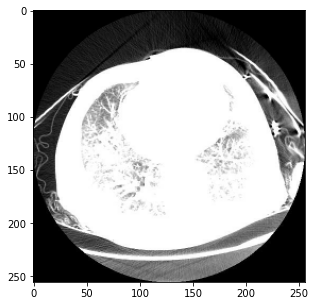

In [102]:
plt.figure(figsize = (10,5))
plt.imshow(img_1.astype(int))
plt.show()

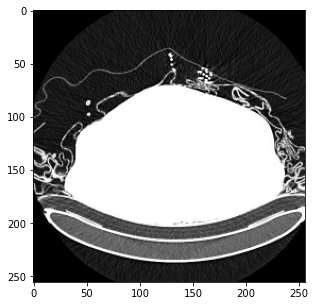

In [103]:
plt.figure(figsize = (10,5))
plt.imshow(img_2.astype(int))
plt.show()

as per usual injury = 1 else healthy = 0

In [108]:
data_spleen_level_1 = data_spleen_level_1.map(lambda x, y  : (x/255 , y))

In [109]:
scaled_iterator_spleen_level_1 = data_spleen_level_1.as_numpy_iterator()

In [110]:
batch_spleen_level_1 = scaled_iterator_spleen_level_1.next()

In [111]:
sample = batch_spleen_level_1[0][0]
np.min(sample) , np.max(sample)

(0.0, 1.0)

In [112]:
len(data_spleen_level_1)

7

In [113]:
train_size = 4
val_size = 2
test_size = 1

In [114]:
train_spleen_level_1 = data_spleen_level_1.take(train_size)
val_spleen_level_1 = data_spleen_level_1.skip(train_size).take(val_size)
test_spleen_level_1 = data_spleen_level_1.skip(train_size + val_size).take(test_size)

In [115]:
model_spleen_level_1 = Sequential()

In [116]:
model_spleen_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_spleen_level_1.add(MaxPooling2D())            

model_spleen_level_1.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_spleen_level_1.add(MaxPooling2D())

model_spleen_level_1.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_spleen_level_1.add(MaxPooling2D())

model_spleen_level_1.add(Flatten())          

model_spleen_level_1.add(Dense(256, activation = 'relu'))
model_spleen_level_1.add(Dense(1, activation = 'sigmoid'))

In [117]:
model_spleen_level_1.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [118]:
model_spleen_level_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [119]:
logdir_spleen_level_1 = os.path.join(expanded_path , 'spleen_label_class', 'logs_spleen_level_1')

In [120]:
tensorboard_callback_spleen_level_1 = tf.keras.callbacks.TensorBoard(log_dir = logdir_spleen_level_1)

In [121]:
hist_spleen_level_1 = model_spleen_level_1.fit(train_spleen_level_1, epochs = 20 , validation_data = val_spleen_level_1, callbacks = [tensorboard_callback_spleen_level_1])

Epoch 1/20
4/4 [==============================] - 17s 3s/step - loss: 0.5613 - accuracy: 0.7344 - val_loss: 0.4053 - val_accuracy: 0.7344
Epoch 2/20
4/4 [==============================] - 10s 2s/step - loss: 0.3163 - accuracy: 0.8516 - val_loss: 0.1647 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 0.1150 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 10s 2s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 9.3547e-04 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 10s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.3176e-05 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 10s 2s/step - loss: 4.2052e-04 - accuracy: 1.0000 - val_loss: 3.6582e-04 - val_accuracy: 1.0000
Epoch 8/20
4/4 [====

In [123]:
pre_spleen_level_1 = Precision()
re_spleen_level_1 = Recall()
acc_spleen_level_1 = BinaryAccuracy()

for batch in test_spleen_level_1.as_numpy_iterator():
    X , y = batch
    yhat = model_spleen_level_1.predict(X)
    pre_spleen_level_1.update_state(y, yhat)
    re_spleen_level_1.update_state(y, yhat)
    acc_spleen_level_1.update_state(y, yhat)

1/1 [==============================] - 1s 821ms/step


In [124]:
pre_spleen_level_1.result().numpy() , re_spleen_level_1.result().numpy() , acc_spleen_level_1.result().numpy()

(1.0, 1.0, 1.0)

In [125]:
def spleen_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'spleen_healthy' : [] , 'spleen_injury' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_spleen_level_1 = cv2.imread(image_path)
            resize = tf.image.resize(image_spleen_level_1, (256,256))
            yhat_spleen_level_1= model_spleen_level_1.predict(np.expand_dims(resize/255 , 0))
            spleen_injury = float(yhat_spleen_level_1)
            spleen_healthy = float(1 - yhat_spleen_level_1)
            data['spleen_healthy'].append(spleen_healthy)
            data['spleen_injury'].append(spleen_injury)
        
    spleen_df = pd.DataFrame(data)
    spleen_df.to_csv('spleen_prediction.csv' , index = False)
    
    return spleen_df

In [128]:
jpeg_directory = os.path.join(expanded_path, 'spleen_label_class', 'spleen_test_level_1')
patient_id = [48843]
spleen_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 141ms/step


,patient_id,spleen_healthy,spleen_injury
0,48843,5.960464e-08,1.0


# Part 6 : Eighth Task : Classification of level 2 : Neural Network Model for spleen_[injury/healthy] Prediction (the fifth label class)

In [129]:
data_spleen_level_2 = tf.keras.utils.image_dataset_from_directory(os.path.join(expanded_path ,'spleen_label_class' ,'spleen_JPG', 'data_spleen_level_2') , shuffle = True)

Found 162 files belonging to 2 classes.


In [130]:
len(data_spleen_level_2)

6

In [132]:
data_iterator_spleen_level_2 = data_spleen_level_2.as_numpy_iterator()

In [133]:
batch_spleen_level_2 = data_iterator_spleen_level_2.next()

In [134]:
batch_spleen_level_2

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [135]:
data_spleen_level_2 = data_spleen_level_2.map(lambda x,y : (x/255 , y))

In [136]:
scaled_iterator_spleen_level_2 = data_spleen_level_2.as_numpy_iterator()

In [137]:
batch_spleen_level_2 = scaled_iterator_spleen_level_2.next()

In [138]:
np.min(batch_spleen_level_2[0]) , np.max(batch_spleen_level_2[0])

(0.0, 1.0)

In [139]:
len(data_spleen_level_2)

6

In [140]:
train_size = 3
val_size = 2
test_size = 1

In [141]:
train_spleen_level_2 = data_spleen_level_2.take(train_size)
val_spleen_level_2 = data_spleen_level_2.skip(train_size).take(val_size)
test_spleen_level_2 = data_spleen_level_2.skip(train_size + val_size).take(test_size)

In [150]:
model_spleen_level_2 = Sequential()

In [151]:
model_spleen_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' , input_shape=(256,256,3)))    
model_spleen_level_2.add(MaxPooling2D())            

model_spleen_level_2.add(Conv2D(32, (3,3), 1 , activation = 'relu' ))
model_spleen_level_2.add(MaxPooling2D())

model_spleen_level_2.add(Conv2D(16, (3,3), 1 , activation = 'relu' ))
model_spleen_level_2.add(MaxPooling2D())

model_spleen_level_2.add(Flatten())          

model_spleen_level_2.add(Dense(256, activation = 'relu'))
model_spleen_level_2.add(Dense(1, activation = 'sigmoid'))

In [152]:
model_spleen_level_2.compile('adam' , loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [153]:
model_spleen_level_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 16)       

In [155]:
logdir_spleen_level_2 = os.path.join(expanded_path , 'spleen_label_class', 'logs_spleen_level_2')

In [156]:
tensorboard_callback_spleen_level_2 = tf.keras.callbacks.TensorBoard(log_dir = logdir_spleen_level_2)

In [157]:
hist_spleen_level_2 = model_spleen_level_2.fit(train_spleen_level_2, epochs = 20 , validation_data = val_spleen_level_2, callbacks = [tensorboard_callback_spleen_level_2])

Epoch 1/20
3/3 [==============================] - 15s 3s/step - loss: 0.7730 - accuracy: 0.4896 - val_loss: 0.5038 - val_accuracy: 0.5312
Epoch 2/20
3/3 [==============================] - 8s 2s/step - loss: 0.3253 - accuracy: 0.8438 - val_loss: 0.1345 - val_accuracy: 0.9688
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 0.0731 - accuracy: 0.9896 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 6.7442e-04 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 8s 2s/step - loss: 3.5940e-04 - accuracy: 1.0000 - val_loss: 6.4076e-05 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 8s 2s/step - loss: 2.6576e-05 - accuracy: 1.0000 - val_loss: 1.7384e-05 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 1.3265e-05 - accuracy: 1.0000 - val_loss: 2.2672e-06 - val_accuracy: 1.0000
Epoch 8/20
3

In [158]:
pre_spleen_level_2 = Precision()
re_spleen_level_2 = Recall()
acc_spleen_level_2 = BinaryAccuracy()

for batch in test_spleen_level_2.as_numpy_iterator():
    X , y = batch
    yhat = model_spleen_level_2.predict(X)
    pre_spleen_level_2.update_state(y, yhat)
    re_spleen_level_2.update_state(y, yhat)
    acc_spleen_level_2.update_state(y, yhat)

1/1 [==============================] - 0s 396ms/step


In [159]:
pre_spleen_level_2.result().numpy() , re_spleen_level_2.result().numpy() , acc_spleen_level_2.result().numpy()

(1.0, 1.0, 1.0)

In [160]:
def spleen_low_high_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'spleen_low' : [] , 'spleen_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_spleen_level_2 = cv2.imread(image_path)
            resize = tf.image.resize(image_spleen_level_2, (256,256))
            yhat_spleen_level_2= model_spleen_level_2.predict(np.expand_dims(resize/255 , 0))
            spleen_injury_low = float(yhat_spleen_level_2)
            spleen_injury_high = float(1 - yhat_spleen_level_2)
            data['spleen_low'].append(spleen_injury_low)
            data['spleen_high'].append(spleen_injury_high)
        
    spleen_low_high_df = pd.DataFrame(data)
    spleen_low_high_df.to_csv('spleen_low_high.csv' , index = False)
    
    return spleen_low_high_df

In [163]:
jpeg_directory = os.path.join(expanded_path, 'spleen_label_class', 'spleen_test_level_2')
patient_id = [48843]
spleen_low_high_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 127ms/step


,patient_id,spleen_low,spleen_high
0,48843,1.0,0.0


# Part 6 : nineth Task : Regrouping of Levels 1 and 2 : Neural Network Model for spleen_[injury/healthy] Prediction (the fifth label class)

In [323]:
def spleen_finally_prediction(jpeg_directory , patient_id):
    
    # jpeg_directory :  is the directory where the test set images are located 
    # patient_id : list of patient_id that we have in our test set, i mean your hidden test set  (type  list)
    
    data = {'patient_id' : patient_id , 'spleen_healthy' : [] , 'spleen_low' : [] , 'spleen_high' : [] }
    
    for image in os.listdir(jpeg_directory):
        
        if image.endswith('.jpg'):
            
            image_path = os.path.join(jpeg_directory, image)
            image_spleen = cv2.imread(image_path)
            resize = tf.image.resize(image_spleen, (256,256))
            yhat_spleen_level_1 = model_spleen_level_1.predict(np.expand_dims(resize/255 , 0))
            yhat_spleen_level_2 = model_spleen_level_2.predict(np.expand_dims(resize/255 , 0))
            spleen_injury = float(yhat_spleen_level_1)
            spleen_healthy = float(1 - yhat_spleen_level_1)
            spleen_injury_low = float(yhat_spleen_level_2)
            spleen_injury_high = float(1 - yhat_spleen_level_2)
            spleen_low = spleen_injury*spleen_injury_low
            spleen_high = spleen_injury*spleen_injury_high
            data['spleen_healthy'].append(spleen_healthy)
            data['spleen_low'].append(spleen_low)
            data['spleen_high'].append(spleen_high)
        
    spleen_df = pd.DataFrame(data)
    spleen_df.to_csv('spleen_prediction.csv' , index = False)
    
    return spleen_df

In [170]:
jpeg_directory = os.path.join(expanded_path, 'spleen_label_class', 'spleen_test_level_2')
patient_id = [48843]
spleen_finally_prediction(jpeg_directory , patient_id)

1/1 [==============================] - 0s 111ms/step


,patient_id,spleen_healthy,spleen_low,spleen_high
0,48843,0.0,1.0,0.0


# Part 7 : Final assignment

In [381]:
def final_prediction_RSNA(jpeg_directory , patient_id) :
    
    df1 = bowel_prediction(jpeg_directory , patient_id)
    bowel = df1[['patient_id' , 'bowel_healthy' , 'bowel_injury' ]]
    df2 = extravasation_prediction(jpeg_directory , patient_id)
    extravasation = df2[['extravasation_healthy' , 'extravasation_injury' ]]
    df3 = kidney_finally_prediction(jpeg_directory , patient_id)
    kidney = df3[['kidney_healthy' , 'kidney_low' , 'kidney_high']]
    df4 = liver_finally_prediction(jpeg_directory , patient_id)
    liver = df4[['liver_healthy' , 'liver_low' , 'liver_high']]
    df5 = spleen_finally_prediction(jpeg_directory , patient_id)
    spleen = df5[['spleen_healthy' , 'spleen_low' , 'spleen_high']]
    
    df = pd.concat([bowel, extravasation, kidney, liver, spleen], axis = 1)
    df.to_csv('submission.csv', index = False)
    
    return df


# Exemple testing 

In [382]:
jpeg_directory = os.path.join(expanded_path, 'final_test')
patient_id = [1 ,2 ,3]
final_prediction_RSNA(jpeg_directory , patient_id)

1/1 [==============================] - 0s 126ms/step


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,1,1.000000e+00,1.432006e-10,6.556511e-07,9.999993e-01,0.000000,1.000000e+00,0.000000e+00,0.999995,5.115153e-06,1.288471e-09,0.000000e+00,4.077583e-11,1.0
1,2,0.000000e+00,1.000000e+00,1.000000e+00,7.934153e-11,0.000079,9.458369e-10,9.999205e-01,0.000005,9.999952e-01,0.000000e+00,1.192093e-07,9.999999e-01,0.0
2,3,8.344650e-07,9.999992e-01,1.000000e+00,6.394768e-15,1.000000,7.092066e-18,4.117212e-07,0.000000,3.966086e-10,1.000000e+00,1.000000e+00,1.437916e-12,0.0


# The End 'HAMDOLILAH'